In [1]:
%load_ext autoreload
%autoreload 2

from vflow import Vset, build_vset, init_args, dict_to_df, perturbation_stats
from vflow.pipeline import build_graph

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from sklearn.impute import KNNImputer, SimpleImputer

import numpy as np
import pandas as pd

pd.options.display.max_rows = 8
np.random.seed(31415)

In [2]:
X, y = make_regression(n_samples=1000, n_features=3, n_informative=1)

# 20% of X entries missing
i = np.random.randint(X.shape[0], size=round(X.shape[0]*X.shape[1] * 0.2))
j = np.random.randint(X.shape[1], size=i.size)
X[i, j] = np.nan

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval)

X_train, y_train = init_args([X_train, y_train], names=['X_train', 'y_train'])
X_val, y_val = init_args([X_val, y_val], names=['X_val', 'y_val'])

In [3]:
from vflow import Vset
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.inspection import permutation_importance

preproc_list = [SimpleImputer(strategy='mean'),
                SimpleImputer(strategy='median'),
                KNNImputer()]

# create a Vset which varies over the list of preprocessing methods
preproc_set = Vset("preproc", preproc_list, ['mean', 'med', 'knn'], output_matching=True)

# create the feature importance Vset
feat_imp_set = build_vset('feat_imp', permutation_importance, n_repeats=3)

In [4]:
from sklearn.ensemble import RandomForestRegressor as RF
from vflow import build_vset

# hyperparameters to try
RF_params = {
    'n_estimators': [100, 300],
    'min_samples_split': [2, 10]
}

# we could instead pass a list of distinct models and corresponding param dicts
RF_set = build_vset('RF', RF, RF_params)

In [5]:
from sklearn.utils import resample

# create a Vset for bootstrapping from data 10 times
# we use lazy=True so that the data will not be resampled until needed
boot_set = build_vset('boot', resample, reps=10, lazy=True)

In [6]:
%%time

# bootstrap from training data by calling boot_fun
X_trains, y_trains = boot_set(X_train, y_train)

# apply three preprocessing methods to each bootstrap sample
X_trains = preproc_set.fit_transform(X_trains)

# this results in fitting all 4 RF models to each of the 300 boot/preproc combos
RF_set.fit(X_trains, y_trains)

CPU times: user 49.7 s, sys: 615 ms, total: 50.3 s
Wall time: 50.3 s


/home/james/school/yugroup/projects/pcs_inference/pcs_pipeline/veridical-flow/vflow/pipeline.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


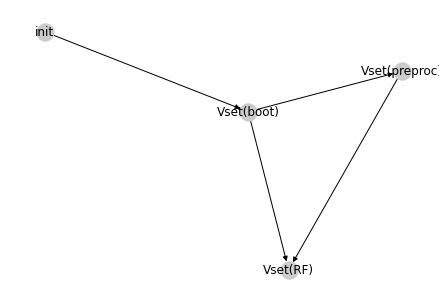

In [7]:
from vflow import build_graph

# examine the pipeline graph
build_graph(RF_set)

In [8]:
%%time

from vflow import dict_to_df, perturbation_stats

# calculate importances
importances = feat_imp_set.evaluate(RF_set.out, preproc_set.fit_transform(X_val), y_val)

CPU times: user 25.5 s, sys: 24 ms, total: 25.5 s
Wall time: 25.5 s


In [9]:
# the helper dict_to_df converts the output to a pandas.DataFrame
# using param_key='out' separates the importance dict into multiple cols
importances_df = dict_to_df(importances, param_key='out')
importances_df

,init-boot,boot,init-preproc,preproc,init-RF,RF,init-feat_imp,init-feat_imp,init-feat_imp,feat_imp,out,out-importances_mean,out-importances_std,out-importances
0,X_train,"(rep=0,)",X_train,mean,y_train,"(n_estimators=100, min_samples_split=2)",X_val,X_val,y_val,feat_imp_0,"{'importances_mean': [-0.04233634837216912, -0...","[-0.04233634837216912, -0.027757007166214875, ...","[0.024924678381603792, 0.01683543513535128, 0....","[[-0.007237119193629127, -0.057076608597207645..."
1,X_train,"(rep=1,)",X_train,mean,y_train,"(n_estimators=100, min_samples_split=2)",X_val,X_val,y_val,feat_imp_0,"{'importances_mean': [0.01839422558752039, 0.0...","[0.01839422558752039, 0.042711479268497686, 1....","[0.0036565791683874777, 0.024248707247297843, ...","[[0.023523528952571038, 0.01639838148580597, 0..."
2,X_train,"(rep=2,)",X_train,mean,y_train,"(n_estimators=100, min_samples_split=2)",X_val,X_val,y_val,feat_imp_0,"{'importances_mean': [-0.008302930606616354, 0...","[-0.008302930606616354, 0.0177609561581004, 1....","[0.009404206935710093, 0.007448068014780976, 0...","[[-0.016919521392400827, 0.004778872326435479,..."
3,X_train,"(rep=3,)",X_train,mean,y_train,"(n_estimators=100, min_samples_split=2)",X_val,X_val,y_val,feat_imp_0,"{'importances_mean': [-0.011638433089425693, 0...","[-0.011638433089425693, 0.00441122785845068, 1...","[0.004962647257262718, 0.011554546703690473, 0...","[[-0.009525831641231663, -0.01849080904085043,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,X_train,"(rep=6,)",X_train,knn,y_train,"(n_estimators=300, min_samples_split=10)",X_val,X_val,y_val,feat_imp_0,"{'importances_mean': [0.0013520311839704258, -...","[0.0013520311839704258, -0.010863592214964172,...","[0.005813794379642768, 0.015146096499531523, 0...","[[-0.004240475135807165, -0.001071218738866619..."
117,X_train,"(rep=7,)",X_train,knn,y_train,"(n_estimators=300, min_samples_split=10)",X_val,X_val,y_val,feat_imp_0,"{'importances_mean': [-0.003229574147788091, -...","[-0.003229574147788091, -0.008307924721150458,...","[0.0007484332199679789, 0.007173602910324836, ...","[[-0.0027391744025062614, -0.00428709138113114..."
118,X_train,"(rep=8,)",X_train,knn,y_train,"(n_estimators=300, min_samples_split=10)",X_val,X_val,y_val,feat_imp_0,"{'importances_mean': [-0.011348925421541348, 0...","[-0.011348925421541348, 0.017103179568118725, ...","[0.0038008072310313, 0.012277653726929369, 0.1...","[[-0.013432921481068671, -0.006016015632128502..."
119,X_train,"(rep=9,)",X_train,knn,y_train,"(n_estimators=300, min_samples_split=10)",X_val,X_val,y_val,feat_imp_0,"{'importances_mean': [-0.01751267608504507, -0...","[-0.01751267608504507, -0.012979887477715502, ...","[0.005890013857352848, 0.014135737708139744, 0...","[[-0.01622471053173602, -0.02528366758975864, ..."


In [10]:
# get count, mean, and std of importances
perturbation_stats(importances_df, 'preproc', 'RF', wrt_col='out-importances_mean', prefix='X', split=True)

,preproc,RF,X-count,X0-mean,X0-std,X1-mean,X1-std,X2-mean,X2-std
0,knn,"(n_estimators=100, min_samples_split=10)",10,-0.002969,0.012915,-0.000128,0.012026,1.413734,0.059397
1,knn,"(n_estimators=100, min_samples_split=2)",10,-0.007716,0.008911,-0.009908,0.010928,1.406988,0.062152
2,knn,"(n_estimators=300, min_samples_split=10)",10,-0.005769,0.008482,-0.006782,0.010586,1.355347,0.069970
3,knn,"(n_estimators=300, min_samples_split=2)",10,-0.002253,0.010559,-0.005499,0.012924,1.447590,0.058728
...,...,...,...,...,...,...,...,...,...
8,med,"(n_estimators=100, min_samples_split=10)",10,-0.003492,0.007709,0.005208,0.022189,1.468638,0.070566
9,med,"(n_estimators=100, min_samples_split=2)",10,0.002673,0.012697,-0.000677,0.029884,1.491641,0.063814
10,med,"(n_estimators=300, min_samples_split=10)",10,0.002116,0.012346,0.001404,0.020467,1.459505,0.080740
11,med,"(n_estimators=300, min_samples_split=2)",10,0.002549,0.014764,0.008233,0.022524,1.530841,0.078636
